In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli


Dataset shape: (1797, 64)
Number of classes: 10


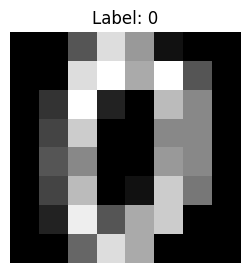

In [12]:
digits = load_digits()
X = digits.data
y = digits.target

print("Dataset shape:", X.shape)
print("Number of classes:", len(np.unique(y)))

plt.figure(figsize=(3,3))
plt.imshow(digits.images[0], cmap="gray")
plt.title(f"Label: {y[0]}")
plt.axis("off")
plt.show()


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (1437, 64)  Test: (360, 64)


In [14]:
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaled train range:", X_train_scaled.min(), "to", X_train_scaled.max())


Scaled train range: 0.0 to 3.141592653589793


In [17]:
d = 10  # target embedding dimension

clf_raw = LogisticRegression(max_iter=3000)
clf_raw.fit(X_train_scaled, y_train)
raw_acc = clf_raw.score(X_test_scaled, y_test)
print("Baseline (Raw 64D) Test Accuracy:", raw_acc)


pca_baseline = PCA(n_components=d, random_state=42)
X_train_pca = pca_baseline.fit_transform(X_train_scaled)
X_test_pca  = pca_baseline.transform(X_test_scaled)

clf_pca = LogisticRegression(max_iter=3000)
clf_pca.fit(X_train_pca, y_train)
pca_acc = clf_pca.score(X_test_pca, y_test)
print(f"Baseline (PCA {d}D) Test Accuracy:", pca_acc)


rp = GaussianRandomProjection(n_components=d, random_state=42)
X_train_classical_rp = rp.fit_transform(X_train_scaled)
X_test_classical_rp  = rp.transform(X_test_scaled)

clf_c = LogisticRegression(max_iter=3000)
clf_c.fit(X_train_classical_rp, y_train)
classical_rp_acc = clf_c.score(X_test_classical_rp, y_test)
print(f"Classical RP ({d}D) Test Accuracy:", classical_rp_acc)



Baseline (Raw 64D) Test Accuracy: 0.9583333333333334
Baseline (PCA 10D) Test Accuracy: 0.9222222222222223
Classical RP (10D) Test Accuracy: 0.7583333333333333


In [18]:
n_qubits = 6

pca_to_qubits = PCA(n_components=n_qubits, random_state=42)
X_train_qubit_in = pca_to_qubits.fit_transform(X_train_scaled)
X_test_qubit_in  = pca_to_qubits.transform(X_test_scaled)

# scale again to [0, π] after PCA (important)
scaler_q = MinMaxScaler(feature_range=(0, np.pi))
X_train_qubit_in = scaler_q.fit_transform(X_train_qubit_in)
X_test_qubit_in  = scaler_q.transform(X_test_qubit_in)

print("Quantum input shape:", X_train_qubit_in.shape, X_test_qubit_in.shape)
print("Quantum input range:", X_train_qubit_in.min(), "to", X_train_qubit_in.max())


Quantum input shape: (1437, 6) (360, 6)
Quantum input range: 0.0 to 3.141592653589794


In [19]:
def make_random_params(n_qubits, depth, seed=42):
    rng = np.random.default_rng(seed)
    # random angles for "mixing" rotations
    theta = rng.uniform(0, 2*np.pi, size=(depth, n_qubits))
    phi   = rng.uniform(0, 2*np.pi, size=(depth, n_qubits))
    return theta, phi

def quantum_random_projection(features, theta, phi, depth=2):
    """
    features: shape (n_qubits,) already scaled to [0, π]
    theta, phi: fixed random parameters (data-independent)
    returns: vector of length d (here 10)
    """
    n_qubits = len(features)
    qc = QuantumCircuit(n_qubits)

    for layer in range(depth):
        # --- Data re-uploading / encoding ---
        for i, x in enumerate(features):
            qc.ry(x, i)

        # --- Random mixing (data-independent randomness) ---
        for i in range(n_qubits):
            qc.rz(theta[layer, i], i)
            qc.ry(phi[layer, i], i)

        # --- Entanglement ---
        for i in range(n_qubits - 1):
            qc.cz(i, i + 1)

    state = Statevector.from_instruction(qc)

    # --- Measurements/features (10 dims total) ---
    # First 6: <Zi>
    feats = []
    for i in range(n_qubits):
        pauli = Pauli("I"*i + "Z" + "I"*(n_qubits-i-1))
        feats.append(np.real(state.expectation_value(pauli)))

    # Next 4: <Zi Zi+1> for i=0..3  (total 10 features)
    for i in range(4):
        s = ["I"] * n_qubits
        s[i] = "Z"
        s[i+1] = "Z"
        pauli = Pauli("".join(s))
        feats.append(np.real(state.expectation_value(pauli)))

    return np.array(feats)

# fixed random circuit parameters
depth = 2
theta, phi = make_random_params(n_qubits=n_qubits, depth=depth, seed=42)

# build embeddings
X_train_quantum_rp = np.array([quantum_random_projection(x, theta, phi, depth=depth) for x in X_train_qubit_in])
X_test_quantum_rp  = np.array([quantum_random_projection(x, theta, phi, depth=depth) for x in X_test_qubit_in])

print("Quantum RP shapes:", X_train_quantum_rp.shape, X_test_quantum_rp.shape)
print("Quantum RP dimension:", X_train_quantum_rp.shape[1])


Quantum RP shapes: (1437, 10) (360, 10)
Quantum RP dimension: 10


In [20]:
clf_q = LogisticRegression(max_iter=3000)
clf_q.fit(X_train_quantum_rp, y_train)

quantum_rp_acc = clf_q.score(X_test_quantum_rp, y_test)
print(f"Quantum RP ({d}D) Test Accuracy:", quantum_rp_acc)


Quantum RP (10D) Test Accuracy: 0.7388888888888889


In [21]:
print("\n==== Test Accuracy Summary ====")
print(f"Raw 64D           : {raw_acc:.4f}")
print(f"PCA {d}D           : {pca_acc:.4f}")
print(f"Classical RP {d}D  : {classical_rp_acc:.4f}")
print(f"Quantum RP {d}D    : {quantum_rp_acc:.4f}")



==== Test Accuracy Summary ====
Raw 64D           : 0.9583
PCA 10D           : 0.9222
Classical RP 10D  : 0.7583
Quantum RP 10D    : 0.7389


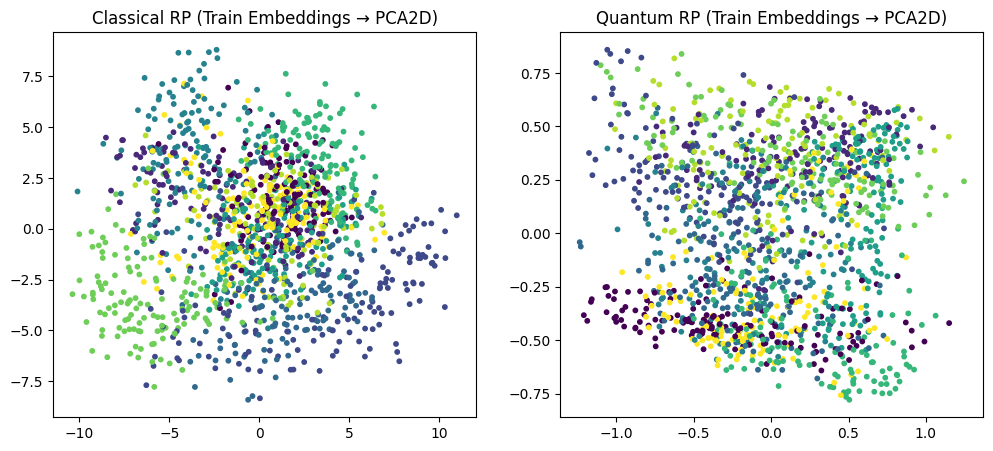

In [22]:
pca_vis_c = PCA(n_components=2, random_state=42)
pca_vis_q = PCA(n_components=2, random_state=42)

Xc_2d = pca_vis_c.fit_transform(X_train_classical_rp)
Xq_2d = pca_vis_q.fit_transform(X_train_quantum_rp)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(Xc_2d[:,0], Xc_2d[:,1], c=y_train, s=10)
ax[0].set_title("Classical RP (Train Embeddings → PCA2D)")

ax[1].scatter(Xq_2d[:,0], Xq_2d[:,1], c=y_train, s=10)
ax[1].set_title("Quantum RP (Train Embeddings → PCA2D)")

plt.show()


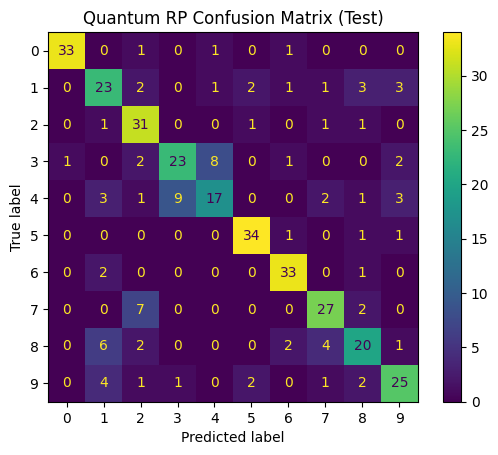

In [23]:
y_pred_q = clf_q.predict(X_test_quantum_rp)

cm = confusion_matrix(y_test, y_pred_q)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Quantum RP Confusion Matrix (Test)")
plt.show()
